In [36]:
import pandas as pd
import numpy as np
import seaborn as sns

In [37]:
items = pd.read_csv("data/items.csv")
items_categories = pd.read_csv("data/item_categories.csv")
sales_train = pd.read_csv("data/sales_train.csv")
shops = pd.read_csv("data/shops.csv")

df = pd.merge(items, items_categories, on="item_category_id", how="inner")
df = pd.merge(df, sales_train, on="item_id", how="inner")
df.head()

,item_name,item_id,item_category_id,item_category_name,date,date_block_num,shop_id,item_price,item_cnt_day
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,01.09.2014,20,54,58.0,1.0
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,24.08.2014,19,54,58.0,1.0
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,12.11.2014,22,54,58.0,1.0
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,05.07.2014,18,54,100.0,1.0
4,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,26.08.2014,19,54,58.0,1.0


## DELETE OUTLIERS

In [38]:
df["item_cnt_day"].value_counts()

1.0      2629372
2.0       194201
3.0        47350
4.0        19685
5.0        10474
          ...   
179.0          1
187.0          1
194.0          1
195.0          1
508.0          1
Name: item_cnt_day, Length: 198, dtype: int64

### Take 99th percentile of sells in a day

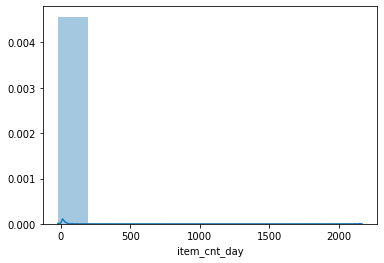

In [39]:
g = sns.distplot(a = df["item_cnt_day"], bins=10)

In [40]:
print(len(df))
df = df[df["item_cnt_day"] <= np.percentile(a=df["item_cnt_day"], q=99)]
print(len(df))
df.head()

2935849
2908438


,item_name,item_id,item_category_id,item_category_name,date,date_block_num,shop_id,item_price,item_cnt_day
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,01.09.2014,20,54,58.0,1.0
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,24.08.2014,19,54,58.0,1.0
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,12.11.2014,22,54,58.0,1.0
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,05.07.2014,18,54,100.0,1.0
4,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,26.08.2014,19,54,58.0,1.0


### Delete negative item_cnt_day -> Devolutions

In [41]:
(df["item_cnt_day"] < 0).sum()

7356

In [42]:
print(len(df))
df = df[df["item_cnt_day"] > 0]
print(len(df))
df.head()

2908438
2901082


,item_name,item_id,item_category_id,item_category_name,date,date_block_num,shop_id,item_price,item_cnt_day
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,01.09.2014,20,54,58.0,1.0
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,24.08.2014,19,54,58.0,1.0
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,12.11.2014,22,54,58.0,1.0
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,05.07.2014,18,54,100.0,1.0
4,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,26.08.2014,19,54,58.0,1.0


## DEFINE FEATURES PARAMETERS

In [43]:
month_to_predict = 30
max_train_month = 29
features_folder_name = "features_train_4/"

In [44]:
df = df[df["date_block_num"] < month_to_predict]
assert(df["date_block_num"].max() == max_train_month)
print("Maximum month in features after processing will be:", df.date_block_num.value_counts().index.max())
df.head()

Maximum month in features after processing will be: 29


,item_name,item_id,item_category_id,item_category_name,date,date_block_num,shop_id,item_price,item_cnt_day
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,01.09.2014,20,54,58.0,1.0
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,24.08.2014,19,54,58.0,1.0
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,12.11.2014,22,54,58.0,1.0
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,05.07.2014,18,54,100.0,1.0
4,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,26.08.2014,19,54,58.0,1.0


## FEATURES

### Of categories and shops (shop_id & item_category_id)

#### Items sold from the same categorie in the same shop last month

In [45]:
items_same_cat_and_shop = df[df.date_block_num == max_train_month].groupby(["shop_id", "item_category_id"]).agg({"item_cnt_day":"sum"}).reset_index().rename(columns={"item_cnt_day":"sold_cat_last_month_by_shop"})
items_same_cat_and_shop.head()

categories_and_shops = items_same_cat_and_shop
print(len(categories_and_shops))

print(categories_and_shops["sold_cat_last_month_by_shop"].isna().sum())
categories_and_shops.sample(10)

1792
0


,shop_id,item_category_id,sold_cat_last_month_by_shop
692,25,55,507.0
181,6,40,199.0
417,16,22,9.0
409,16,6,5.0
247,7,83,5.0
1783,59,67,4.0
1785,59,70,35.0
242,7,72,27.0
690,25,47,42.0
1666,57,5,2.0


#### Items sold from the same categorie in the same shop historically by month (mean, sum, std, min, max)

In [46]:
items_same_cat_and_shop = df.groupby(["shop_id", "item_category_id", "date_block_num"]).agg({"item_cnt_day":"sum"}).reset_index()

In [47]:
items_same_cat_and_shop.head()

,shop_id,item_category_id,date_block_num,item_cnt_day
0,0,0,1,1.0
1,0,1,1,1.0
2,0,2,0,53.0
3,0,2,1,52.0
4,0,3,0,28.0


In [48]:
items_same_cat_and_shop_h = items_same_cat_and_shop.groupby(["shop_id", "item_category_id"]).agg({"item_cnt_day":["sum", "mean", "std", "min", "max"]}).reset_index()

items_same_cat_and_shop_h.columns = ['_'.join(col).strip() for col in items_same_cat_and_shop_h.columns.values]

items_same_cat_and_shop_h.rename(columns={
   "shop_id_":"shop_id",
    "item_category_id_":"item_category_id",
    "item_cnt_day_sum":"hist_sales_sum_cat_by_shop",
    "item_cnt_day_mean":"hist_sales_mean_cat_by_shop",
    "item_cnt_day_std":"hist_sales_std_cat_by_shop",
    "item_cnt_day_min":"hist_sales_min_cat_by_shop",
    "item_cnt_day_max":"hist_sales_max_cat_by_shop"
}, inplace=True)

print(len(categories_and_shops))
print(len(items_same_cat_and_shop_h))
categories_and_shops = pd.merge(items_same_cat_and_shop_h, categories_and_shops, on=["shop_id", "item_category_id"], how="left")
print(len(categories_and_shops))
categories_and_shops.head()

1792
3204
3204


,shop_id,item_category_id,hist_sales_sum_cat_by_shop,hist_sales_mean_cat_by_shop,hist_sales_std_cat_by_shop,hist_sales_min_cat_by_shop,hist_sales_max_cat_by_shop,sold_cat_last_month_by_shop
0,0,0,1.0,1.0,NaN,1.0,1.0,NaN
1,0,1,1.0,1.0,NaN,1.0,1.0,NaN
2,0,2,105.0,52.5,0.707107,52.0,53.0,NaN
3,0,3,52.0,26.0,2.828427,24.0,28.0,NaN
4,0,4,38.0,19.0,4.242641,16.0,22.0,NaN


In [49]:
categories_and_shops.to_csv("generated/" + features_folder_name + "features_shop_and_categories.csv", index=False)

### Of categories (category_id)

#### Total shops that sell items with that category

In [50]:
df.head()

,item_name,item_id,item_category_id,item_category_name,date,date_block_num,shop_id,item_price,item_cnt_day
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,01.09.2014,20,54,58.0,1.0
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,24.08.2014,19,54,58.0,1.0
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,12.11.2014,22,54,58.0,1.0
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,05.07.2014,18,54,100.0,1.0
4,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,26.08.2014,19,54,58.0,1.0


In [51]:
categories_features = df.groupby("item_category_id").agg({"shop_id":"nunique"}).reset_index().rename(columns={"shop_id":"total_shops_of_category"})
print(len(items_categories))
print(len(categories_features))
categories_features.sample(10)

84
83


,item_category_id,total_shops_of_category
70,71,53
48,49,55
42,43,50
67,68,3
40,41,57
27,27,1
26,26,1
73,74,1
36,37,57
12,12,52


#### Total items by category

In [52]:
items_by_category = df.groupby("item_category_id").agg({"item_id":"nunique"}).reset_index().rename(columns={"item_id":"total_items_of_category"})
items_by_category.sample(7)

,item_category_id,total_items_of_category
19,19,604
62,63,335
72,73,36
40,41,332
61,62,291
51,52,3
81,82,8


In [53]:
print(len(categories_features))
categories_features = pd.merge(categories_features, items_by_category, on="item_category_id", how="inner")
print(len(categories_features))
categories_features.sample(7)

83
83


,item_category_id,total_shops_of_category,total_items_of_category
2,2,54,75
19,19,57,604
75,76,1,296
25,25,54,128
28,28,57,229
35,35,57,4
71,72,58,567


In [54]:
categories_features.to_csv("generated/" + features_folder_name + "features_categories.csv", index=False)

### Of shops (shop_id)

#### Total categories by shop

In [55]:
t_cat_by_shop = df.groupby("shop_id").agg({"item_category_id":"nunique"}).reset_index().rename(columns={"item_category_id":"tot_cat_by_shops"})
t_cat_by_shop.head()

print(len(shops))
shops_features = t_cat_by_shop
print(len(shops_features))
shops_features.sample(10)

60
59


,shop_id,tot_cat_by_shops
7,7,60
0,0,48
2,2,59
27,27,60
49,50,57
57,58,57
31,31,62
55,56,62
56,57,61
44,45,59


#### Number of items sold by shop in the last month

In [56]:
items_sold_last_month = df[df["date_block_num"] == max_train_month].groupby("shop_id").agg({"item_cnt_day":"sum"}).reset_index().rename(columns={"item_cnt_day":"items_sold_last_month"})

shops_features = pd.merge(shops_features, items_sold_last_month, on="shop_id", how="left")
print(shops_features["items_sold_last_month"].isna().sum())
shops_features["items_sold_last_month"] = shops_features["items_sold_last_month"].fillna(0) 
print(len(shops_features))
shops_features.sample(5)

16
59


,shop_id,tot_cat_by_shops,items_sold_last_month
44,45,59,619.0
20,20,9,0.0
45,46,60,1441.0
51,52,60,800.0
50,51,54,659.0


In [57]:
shops_features.to_csv("generated/" + features_folder_name +" features_shops.csv", index=False)

### By item in specific shop (item_id & shop_id)

#### Items sold in shop last month

In [58]:
item_purchases_by_shop_last_month = df[df["date_block_num"] == max_train_month].groupby(["shop_id", "item_id"]).agg({"item_cnt_day":"sum"}).reset_index().rename(columns={"item_cnt_day":"purchases_item_in_shop_last_month"})

features_items_and_shops = item_purchases_by_shop_last_month

features_items_and_shops.sample(10)

,shop_id,item_id,purchases_item_in_shop_last_month
15179,28,21835,1.0
24515,48,4885,1.0
12803,27,6630,1.0
29781,57,10891,1.0
23803,47,5825,4.0
4410,12,16625,1.0
24013,47,13029,1.0
19099,38,4335,1.0
31351,59,1099,1.0
13313,27,15899,1.0


#### Item sold in shop in different months

In [59]:
months = [max_train_month - 1 - i for i in range(5)]
months

[28, 27, 26, 25, 24]

In [60]:
for month in months:
    print(len(features_items_and_shops))
    item_purchases_by_shop_in_month = df[df["date_block_num"] == month].groupby(["shop_id", "item_id"]).agg({"item_cnt_day":"sum"}).reset_index().rename(columns={"item_cnt_day":"purchases_item_in_shop_month_" + str(month_to_predict - month)})
    features_items_and_shops = pd.merge(features_items_and_shops, item_purchases_by_shop_in_month, on=["shop_id", "item_id"], how="outer")
    print(len(features_items_and_shops))

31886
50531
50531
65348
65348
82314
82314
96516
96516
111608


In [61]:
features_items_and_shops.head()

,shop_id,item_id,purchases_item_in_shop_last_month,purchases_item_in_shop_month_2,purchases_item_in_shop_month_3,purchases_item_in_shop_month_4,purchases_item_in_shop_month_5,purchases_item_in_shop_month_6
0,2,486,2.0,NaN,1.0,2.0,3.0,NaN
1,2,792,1.0,1.0,NaN,NaN,2.0,1.0
2,2,949,1.0,1.0,NaN,NaN,1.0,1.0
3,2,950,1.0,NaN,NaN,NaN,NaN,NaN
4,2,1090,1.0,NaN,NaN,NaN,NaN,NaN


#### Historical sales for shop in specific item (sum, mean, std, min, max)

In [62]:
sales_of_item_in_shop_by_month = df.groupby(["item_id", "shop_id", "date_block_num"]).agg({"item_cnt_day":"sum"}).reset_index()
# careful: only considering months that have al least one purchase.
sales_of_item_in_shop_by_month_h = sales_of_item_in_shop_by_month.groupby(["item_id", "shop_id"]).agg({"item_cnt_day": ["mean", "sum", "std", "max", "min"]}).reset_index().rename(columns={"sales_in_month":"average_sales_for_item_and_shop_by_month"})

sales_of_item_in_shop_by_month_h.columns = ['_'.join(col).strip() for col in sales_of_item_in_shop_by_month_h.columns.values]

sales_of_item_in_shop_by_month_h.rename(columns={
   "shop_id_":"shop_id",
    "item_id_":"item_id",
    "item_cnt_day_sum":"hist_sales_sum_item_by_shop",
    "item_cnt_day_mean":"hist_sales_mean_item_by_shop",
    "item_cnt_day_std":"hist_sales_std_item_by_shop",
    "item_cnt_day_min":"hist_sales_min_item_by_shop",
    "item_cnt_day_max":"hist_sales_max_item_by_shop"
}, inplace=True)

print(len(features_items_and_shops))
print(len(sales_of_item_in_shop_by_month_h))
features_items_and_shops = pd.merge(sales_of_item_in_shop_by_month_h, features_items_and_shops, on=["shop_id", "item_id"],how="left")
print(len(features_items_and_shops))

features_items_and_shops.sample(10)

111608
401401
401401


,item_id,shop_id,hist_sales_mean_item_by_shop,hist_sales_sum_item_by_shop,hist_sales_std_item_by_shop,hist_sales_max_item_by_shop,hist_sales_min_item_by_shop,purchases_item_in_shop_last_month,purchases_item_in_shop_month_2,purchases_item_in_shop_month_3,purchases_item_in_shop_month_4,purchases_item_in_shop_month_5,purchases_item_in_shop_month_6
186449,10880,25,1.000000,2.0,0.000000,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
305730,16961,29,1.000000,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
266118,15005,57,2.400000,24.0,0.516398,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
343910,18848,3,1.000000,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
289938,16153,51,1.000000,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
685,51,56,1.428571,10.0,0.534522,2.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0
373839,20338,40,1.750000,7.0,0.500000,2.0,1.0,NaN,NaN,NaN,NaN,NaN,2.0
397306,21929,56,1.142857,8.0,0.377964,2.0,1.0,1.0,NaN,NaN,NaN,1.0,NaN
88238,5576,38,1.125000,9.0,0.353553,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
266519,15021,50,2.000000,6.0,1.000000,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN


#### Time since last and first purchase of item in shop

In [63]:
with_last_purchase_month = df.groupby(["item_id", "shop_id"]).agg({"date_block_num":"max"}).reset_index().rename(columns={"date_block_num":"month_last_purchase_of_item_in_shop"})
with_first_purchase_month = df.groupby(["item_id", "shop_id"]).agg({"date_block_num":"min"}).reset_index().rename(columns={"date_block_num":"month_first_purchase_of_item_in_shop"})

print(len(features_items_and_shops))
features_items_and_shops = pd.merge(features_items_and_shops, with_last_purchase_month, on=["shop_id", "item_id"], how="inner")
features_items_and_shops = pd.merge(features_items_and_shops, with_first_purchase_month, on=["shop_id", "item_id"], how="inner")
print(len(features_items_and_shops))
features_items_and_shops.sample(10)

401401
401401


,item_id,shop_id,hist_sales_mean_item_by_shop,hist_sales_sum_item_by_shop,hist_sales_std_item_by_shop,hist_sales_max_item_by_shop,hist_sales_min_item_by_shop,purchases_item_in_shop_last_month,purchases_item_in_shop_month_2,purchases_item_in_shop_month_3,purchases_item_in_shop_month_4,purchases_item_in_shop_month_5,purchases_item_in_shop_month_6,month_last_purchase_of_item_in_shop,month_first_purchase_of_item_in_shop
366806,19993,16,1.727273,19.0,0.786245,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,17,0
290784,16183,25,1.833333,22.0,1.029857,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,18,0
151521,8911,58,1.000000,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,8,8
338181,18596,27,1.000000,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,3,3
11852,1260,25,1.000000,2.0,0.000000,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,24,22
32923,2457,57,1.000000,3.0,0.000000,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,26,21
301313,16721,39,1.000000,2.0,0.000000,1.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,29,27
199051,11464,27,1.000000,4.0,0.000000,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,6,0
379560,20739,9,6.000000,6.0,NaN,6.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,21,21
102046,6319,28,1.700000,17.0,1.567021,6.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,26,11


#### Number of months in there was a sell of item in shop

In [64]:
total_months_with_sells = df.groupby(["item_id", "shop_id"]).agg({"date_block_num":"nunique"}).reset_index().rename(columns={"date_block_num":"total_months_with_sells_by_item_and_shop"})
total_months_with_sells.sample(7)

,item_id,shop_id,total_months_with_sells_by_item_and_shop
120077,7268,25,4
192645,11143,25,1
125098,7507,26,6
224354,12785,19,2
324549,17906,16,2
66890,4300,31,22
399735,22085,52,3


In [65]:
print(len(features_items_and_shops))
features_items_and_shops = pd.merge(features_items_and_shops, total_months_with_sells, on=["item_id", "shop_id"], how="inner")
print(len(features_items_and_shops))
features_items_and_shops.sample(7)

401401
401401


,item_id,shop_id,hist_sales_mean_item_by_shop,hist_sales_sum_item_by_shop,hist_sales_std_item_by_shop,hist_sales_max_item_by_shop,hist_sales_min_item_by_shop,purchases_item_in_shop_last_month,purchases_item_in_shop_month_2,purchases_item_in_shop_month_3,purchases_item_in_shop_month_4,purchases_item_in_shop_month_5,purchases_item_in_shop_month_6,month_last_purchase_of_item_in_shop,month_first_purchase_of_item_in_shop,total_months_with_sells_by_item_and_shop
256900,14498,46,1.000000,2.0,0.00000,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,15,10,2
218950,12520,32,1.000000,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4,4,1
267055,15043,53,5.000000,5.0,NaN,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,4,4,1
10728,1194,57,1.000000,3.0,0.00000,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,19,15,3
367068,20024,38,1.000000,2.0,0.00000,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,26,13,2
378650,20660,48,1.000000,2.0,0.00000,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,23,16,2
373340,20311,31,4.444444,80.0,8.29757,36.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,26,1,18


In [66]:
df.head()

,item_name,item_id,item_category_id,item_category_name,date,date_block_num,shop_id,item_price,item_cnt_day
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,01.09.2014,20,54,58.0,1.0
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,24.08.2014,19,54,58.0,1.0
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,12.11.2014,22,54,58.0,1.0
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,05.07.2014,18,54,100.0,1.0
4,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,26.08.2014,19,54,58.0,1.0


In [67]:
features_items_and_shops.to_csv("generated/" + features_folder_name + "features_items_and_shop.csv", index=False)

### Of items (item_id)

#### Max, mean, std, and min item price

In [68]:
with_price_features = df.groupby("item_id").agg({"item_price":["max", "mean", "min", "std"]}).reset_index()
with_price_features.columns = ['_'.join(col).strip() for col in with_price_features.columns.values]
with_price_features["diff_price_max_min"] = with_price_features["item_price_max"] - with_price_features["item_price_min"]
with_price_features.rename(columns={"item_id_":"item_id"}, inplace=True)

items_features = with_price_features

items_features.sample(7)

,item_id,item_price_max,item_price_mean,item_price_min,item_price_std,diff_price_max_min
3552,3882,315.0,315.000000,315.0,NaN,0.0
4384,4766,300.0,254.612903,99.0,85.429767,201.0
2571,2834,499.0,374.000000,249.0,176.776695,250.0
11806,12669,399.0,311.500000,99.0,124.642345,300.0
9130,9858,149.0,149.000000,149.0,0.000000,0.0
5097,5528,299.0,166.309375,14.0,115.318961,285.0
6321,6845,299.0,297.556291,190.0,12.502605,109.0


#### Total shops that sell specific item

In [69]:
with_different_shops = df.groupby("item_id").agg({"shop_id":"nunique"}).reset_index().rename(columns={"shop_id":"total_shops_item_is_sell"})

print(len(items_features))
items_features = pd.merge(items_features, with_different_shops, on="item_id", how="inner")
print(len(items_features))

items_features.sample(10)

20533
20533


,item_id,item_price_max,item_price_mean,item_price_min,item_price_std,diff_price_max_min,total_shops_item_is_sell
9511,10262,70.0,70.000000,70.00,0.000000,0.00,1
7758,8378,149.0,147.237255,80.00,9.351814,69.00,32
582,698,272.0,272.000000,272.00,0.000000,0.00,1
17190,18519,3599.0,2795.780000,1838.00,178.600145,1761.00,28
20517,22152,149.0,146.392857,76.00,13.628476,73.00,31
6658,7207,199.0,196.037379,119.54,14.274620,79.46,49
11423,12264,1549.0,1315.333333,498.00,424.311521,1051.00,5
9656,10412,399.0,385.427632,99.00,60.350239,300.00,35
14228,15392,779.0,723.912439,369.00,78.247556,410.00,45
4909,5329,1449.0,1449.000000,1449.00,0.000000,0.00,1


In [70]:
items_features.to_csv("generated/" + features_folder_name + "features_items.csv", index=False)